## 目的: 判定個人所在位置

處理流程:
    1. 資料部分: 目前有2985筆訓練資料(皆為影像檔)，1500筆資料(皆為影像檔)
    2. 了解資料型態
    3. 資料前處理
    4. 模型選擇
    5. 模型測試

資料匯入前，匯入所需要使用的package，此次選用的模型為keras中的Xception

In [5]:
#導入要用到的庫
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob as gb
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
from keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

import sys
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k

資料匯入與觀察csv資料中的label

In [6]:
img_path = gb("./train/*.jpg")
label = pd.read_csv("./train/train.csv")

創建一個以list為概念的框架，將所有label設定在同一個array中。

In [9]:
Y_train = label["label"]
y_train = []

for i in label['label']:
    y_train.append([i])
y_train = label['label'].values

y_train.shape

(2985,)

觀察y_train的類別狀態

In [10]:
y_train

array([12, 12, 12, ..., 13, 13, 13])

In [11]:
label.head()

,id,label
0,0 (1).jpg,12
1,0 (2).jpg,12
2,0 (3).jpg,12
3,0 (4).jpg,12
4,0 (5).jpg,12


觀察每一個類別的影像數量

6     310
8     274
10    260
13    256
4     228
11    215
2     211
3     208
1     192
5     189
14    160
9     141
12    116
7     115
0     110
Name: label, dtype: int64

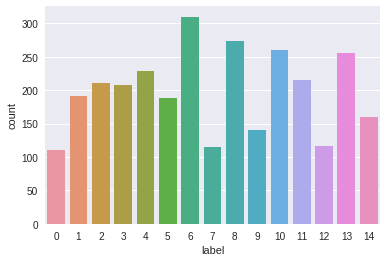

In [12]:
g = sns.countplot(Y_train)

Y_train.value_counts()

將影像資料與label分別作對應

In [14]:
name = []
for path in label['id'].values:
    img  = cv2.imread('./train/'+path)
    img2 = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
    del img
    imga = np.asarray(img2)
    name.append(imga)
name = np.array(name)

name.shape

(2985, 256, 256, 3)

影像讀取，觀察影響狀態

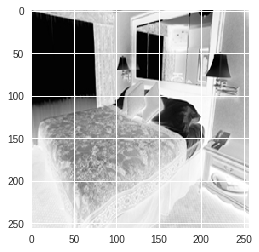

In [15]:
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(name[0][:,:,0])

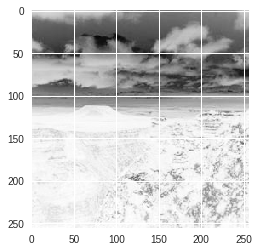

In [16]:
plt.imshow(name[1902][:,:,0])

將pixel值設置0~1之間

In [17]:
name = name / 255.0

把所屬類別的圖片建立 one-hot encoding的樣式

In [18]:
y_train = to_categorical(y_train, num_classes = 15) #one hot

print(y_train[1])

len(y_train)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


2985

將訓練資料進行切割，以0.1比例的資料做為測試集，0.9為訓練集

In [19]:
random_seed = 2 #用random_seed來做作隨機分割

x_train, x_val, y_train, y_val = train_test_split(name, y_train, test_size = 0.1, random_state=random_seed)

建立Xception 的模式，shape部分以256, 256作為 row and col 的像素，再以3通道(RGB)進行設置

In [20]:
base_model = Xception(input_shape=(256, 256, 3), weights='imagenet', include_top=False)

    # Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(15, activation='softmax')(x)

    # add your top layer block to your base model
model = Model(base_model.input, predictions)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

設定一個 優化器，學習率為 0.001，衰減率設為0.9，模糊因子設為 10的-8次方，降解率設0

In [21]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

配置學習過程

In [22]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

如果遇到局部最小值，則將學習率進行減速

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [46]:
epochs = 30 
batch_size = 10

利用imagedatagenerator來旋轉圖片、平移

In [47]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(name)

建立model，觀察準確率，從訊息上來講，此模型的validation value 介於 0.93左右

從準確率來說，此預測結果算是良好，但還是有誤差

In [48]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=name.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 55s - loss: 0.0080 - acc: 0.9973 - val_loss: 0.5975 - val_acc: 0.9164
Epoch 2/30
 - 56s - loss: 0.0092 - acc: 0.9980 - val_loss: 0.6228 - val_acc: 0.9130
Epoch 3/30
 - 56s - loss: 0.0046 - acc: 0.9980 - val_loss: 0.6257 - val_acc: 0.9097
Epoch 4/30
 - 56s - loss: 0.0042 - acc: 0.9983 - val_loss: 0.6462 - val_acc: 0.9130
Epoch 5/30
 - 57s - loss: 0.0032 - acc: 0.9987 - val_loss: 0.6429 - val_acc: 0.9064
Epoch 6/30
 - 56s - loss: 0.0036 - acc: 0.9993 - val_loss: 0.6521 - val_acc: 0.9097
Epoch 7/30
 - 57s - loss: 0.0050 - acc: 0.9983 - val_loss: 0.6426 - val_acc: 0.9130
Epoch 8/30
 - 57s - loss: 0.0034 - acc: 0.9990 - val_loss: 0.6483 - val_acc: 0.9097
Epoch 9/30
 - 57s - loss: 0.0042 - acc: 0.9987 - val_loss: 0.6565 - val_acc: 0.9130
Epoch 10/30
 - 56s - loss: 0.0072 - acc: 0.9973 - val_loss: 0.6591 - val_acc: 0.9097
Epoch 11/30
 - 56s - loss: 0.0070 - acc: 0.9977 - val_loss: 0.6673 - val_acc: 0.9130
Epoch 12/30
 - 56s - loss: 0.0039 - acc: 0.9987 - val_loss: 0.6637 - val_a

In [49]:
model.save("oplast_2.h5")

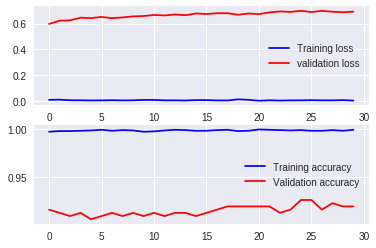

In [50]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

建立一混肴矩陣進行判斷哪一個圖形預測較為不準，從結果上來看 mountain 跟 opencountry的誤差率最高，原因為opencountry的圖樣中，也有山的照片，因而誤判

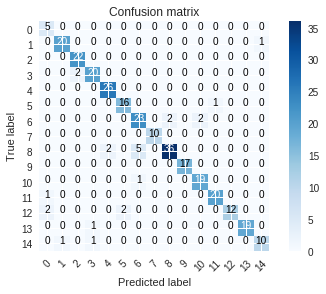

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(15))

In [52]:
label1 = pd.read_csv("./test/test.csv")

print(label1['id'].values[1])

img  = cv2.imread('./test/'+label1['id'].values[1]+'.jpg')

print(img)

96baacc2e97886a998807ce197574821a6dc83c227c7469961c01ab315908371
[[[239 239 239]
  [239 239 239]
  [239 239 239]
  ..., 
  [208 208 208]
  [211 211 211]
  [213 213 213]]

 [[238 238 238]
  [238 238 238]
  [239 239 239]
  ..., 
  [210 210 210]
  [211 211 211]
  [212 212 212]]

 [[237 237 237]
  [237 237 237]
  [237 237 237]
  ..., 
  [211 211 211]
  [210 210 210]
  [209 209 209]]

 ..., 
 [[165 165 165]
  [158 158 158]
  [151 151 151]
  ..., 
  [ 92  92  92]
  [ 89  89  89]
  [ 81  81  81]]

 [[153 153 153]
  [151 151 151]
  [149 149 149]
  ..., 
  [101 101 101]
  [ 96  96  96]
  [ 85  85  85]]

 [[140 140 140]
  [152 152 152]
  [163 163 163]
  ..., 
  [104 104 104]
  [ 96  96  96]
  [ 84  84  84]]]


將測試集資料進行匯入，並且與影像作對應

In [53]:
label1 = pd.read_csv("./test/test.csv")



x_test = [] 
for path in label1['id'].values:
    img  = cv2.imread('./test/'+path+'.jpg')
    img2 = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
    del img
    imga = np.asarray(img2)
    x_test.append(imga)
x_test = np.array(x_test)

將測試集進行資料預測

In [54]:
x_test = x_test.astype('float32') / 255.0

results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,1501),name = "Id"),results],axis = 1)

submission.to_csv("gg256ss.csv",index=False)

![Image of Yaktocat](./kaggle_score.PNG)